$$\large \color{green}{\textbf{Detecting The Toxic Comments With An Artificial Intelligence Model}}$$
$$\small \color{red}{\textbf{The CopyRight @ Phuong V. Nguyen}}$$

$$\small \textbf{}$$

# Loading lib


In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [4]:
from pickle import dump
from pickle import load
Purple= '\033[95m'
Cyan= '\033[96m'
Darkcyan= '\033[36m'
Blue = '\033[94m'
Green = '\033[92m'
Yellow = '\033[93m'
Red = '\033[91m'
Bold = "\033[1m"
Reset = "\033[0;0m"
Underline= '\033[4m'
End = '\033[0m'
from pprint import pprint

# Loading data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Data Analysis (EDA)
## Picking a sample

In [6]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## Data size

In [8]:
print(Bold+'1. The train data size:'+End)
print('The number of rows: %d. The number of columns: %d'%train.shape)
print(Bold+'2. The test data size:'+End)
print('The number of rows: %d. The number of columns: %d'%test.shape)

1. The train data size:
The number of rows: 159571. The number of columns: 8
2. The test data size:
The number of rows: 153164. The number of columns: 2


## Checking the missing value

In [9]:
print(Bold+'1. The missing values in the train data:'+End)
print(train.isnull().sum())
print(Bold+'2. The missing values in the test data:'+End)
print(test.isnull().sum())

1. The missing values in the train data:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
2. The missing values in the test data:
id              0
comment_text    0
dtype: int64


# Data preparation


## Creating the word cloud
### Defining the function

In [10]:
def myword_cloud(data,text,token,width,height,max_font_size, fig_size):
    """
    data: input data
    text: The name of columne presents text, 
          such as "comment_text"
    token: the target feature, such as "toxic".
    width: The width of the word cloud, such as 1600
    height: The height of the word cloud, such as 800
    max_font_size: The maximum size of words, 200
    fig_size: The size of figure, such as (15, 7)
    """
    from wordcloud import WordCloud
    group=data[data[token]==1]
    group_text=group[text]
    neg_text=pd.Series(group_text).str.cat(sep='')
    myWordCloud=WordCloud(width=width, height=height,
                          max_font_size=max_font_size).generate(neg_text)
    plt.figure(figsize=fig_size)
    plt.imshow(myWordCloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"The most common words related to {token}",
              fontsize=20,fontweight='bold')
    plt.show()

### Showing the word cloud

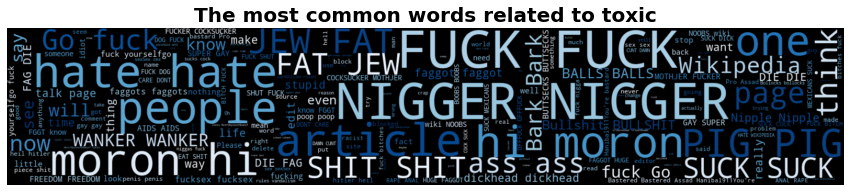

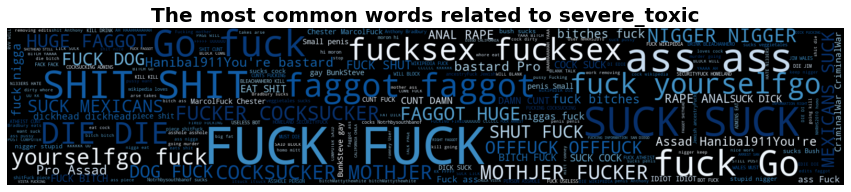

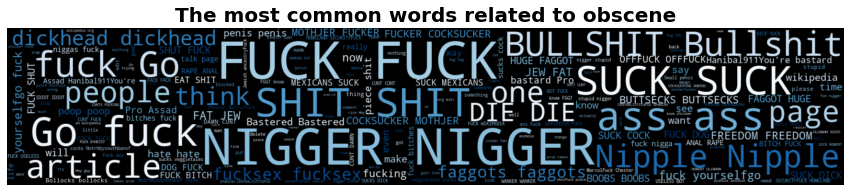

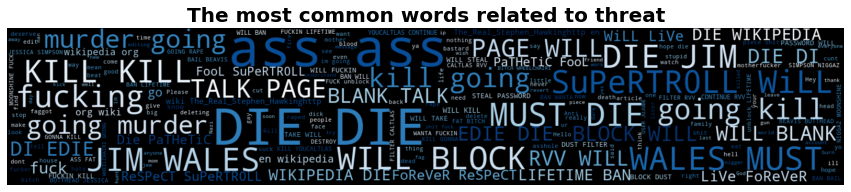

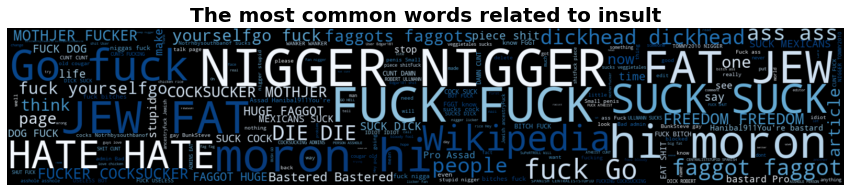

In [11]:
for i,col in enumerate(train.iloc[:,2:-1].columns):
    myword_cloud(data=train,text='comment_text',token=col
             ,width=1600,height=300,max_font_size=100, fig_size=(15,5))

## The input
### Picking up the comment column

In [12]:
comments_train=train['comment_text']
print(Bold+'1. The first five comments in the train data:'+End)
print(comments_train.head(5))
comments_test=test['comment_text']
print(Bold+'2. The first five comments in the test data:'+End)
print(comments_test.head(5))

1. The first five comments in the train data:
0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object
2. The first five comments in the test data:
0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object


### Creating the index for words

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [13]:
max_features=30000
# Creating the function
tokenizer = Tokenizer(num_words=max_features)
# Fitting to data
tokenizer.fit_on_texts(list(comments_train))
# Turning tokens into a list of sequences
list_tokenized_word_train = tokenizer.texts_to_sequences(list(comments_train))
list_tokenized_word_test = tokenizer.texts_to_sequences(list(comments_test))
# List the results
print(Bold+'1. The train data'+End)
print('List of the first %d comments:'% \
      (len(comments_train.head(2))))
print(comments_train.head(2))
print('The index of words in the first %d comments:'% \
      (len(list_tokenized_word_train[:2])))
print(list_tokenized_word_train[:2])
print(Bold+'2. The test data'+End)
print('List of the first %d comments:'% \
      (len(comments_test.head(2))))
print(comments_test.head(2))
print('The index of words in the first %d comments:'% \
      (len(list_tokenized_word_test[:2])))
print(list_tokenized_word_test[:2])

1. The train data
List of the first 2 comments:
0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
Name: comment_text, dtype: object
The index of words in the first 2 comments:
[[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985], [52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]]
2. The test data
List of the first 2 comments:
0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
Name: comment_text, dtype: object
The index of words in the first 2 comments:
[[2665, 655, 8849, 656, 8, 57, 16388, 83, 884, 356, 16, 3222, 76, 21, 6, 4, 6865, 6, 1521, 7, 56, 655, 4942, 1898, 682, 6908, 4, 96, 6, 2, 5104, 29, 417, 6, 726, 35, 8849, 656, 8, 36, 4122, 10, 2818, 660, 437, 4

### Measuring the length of each comment

In [14]:
totalNumWords_train = [len(one_product) for one_product in list_tokenized_word_train]
print(Bold+'1. The train data:'+End)
print('The length of the first %d comments:'% \
      (len(totalNumWords_train[:10])))
print(totalNumWords_train[:10])
totalNumWords_test = [len(one_product) for one_product in list_tokenized_word_test]
print(Bold+'2. The test data:'+End)
print('The length of the first %d comments:'% \
      (len(totalNumWords_test[:10])))
print(totalNumWords_test[:10])

1. The train data:
The length of the first 10 comments:
[47, 17, 42, 114, 13, 11, 8, 19, 84, 11]
2. The test data:
The length of the first 10 comments:
[70, 10, 3, 38, 7, 16, 28, 6, 97, 39]


### The distribution of the length of comments

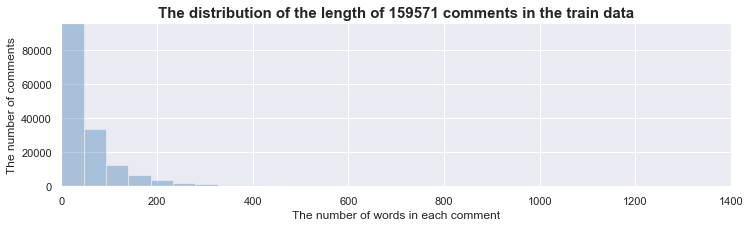

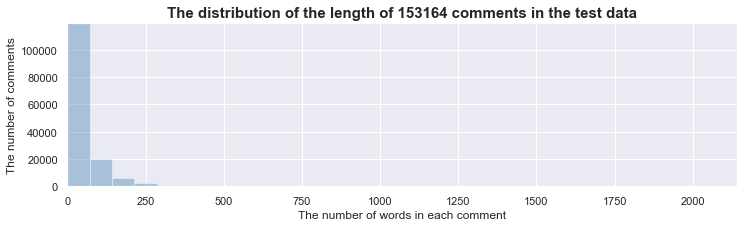

In [15]:
sns.set(color_codes=True)
plt.figure(figsize=(12, 3))
sns.distplot(totalNumWords_train, kde=False, bins=30, color="steelblue")
plt.title('The distribution of the length of %d comments in the train data'%len(train),
         fontsize=15, fontweight='bold')
plt.ylabel('The number of comments',fontsize=12)
plt.xlabel('The number of words in each comment',fontsize=12)
plt.autoscale(enable=True, axis='both',tight=True)
plt.show()
plt.figure(figsize=(12, 3))
sns.distplot(totalNumWords_test, kde=False, bins=30, color="steelblue")
plt.title('The distribution of the length of %d comments in the test data'%len(test),
         fontsize=15, fontweight='bold')
plt.ylabel('The number of comments',fontsize=12)
plt.xlabel('The number of words in each comment',fontsize=12)
plt.autoscale(enable=True, axis='both',tight=True)
plt.show()

$$\textbf{Comments:}$$
Based on two Figures above, the distribution of the length of each comment varies a lot and has the right skew. Moreover, it fairs to say that the majority of comments have a length of 250 words. On the other hand, when we train neural networks for NLP, we need sequences to be in the same size, that’s why we use padding. Indeed, the length of all comments will be synchronized with 250 words using pad as follows.
### Padding


In [16]:
maxlen =250
X_train=pad_sequences(list_tokenized_word_train,maxlen=maxlen)
print(Bold+'The structure of the first comment in the train data:'+End)
print(X_train[:1])
X_test=pad_sequences(list_tokenized_word_test,maxlen=maxlen)
print(Bold+'The structure of the first comment in the test data:'+End)
print(X_test[:1])

The structure of the first comment in the train data:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0   

## The output

In [17]:
comment_types=train.iloc[:,2:-1].columns
print(Bold+'The %d types of comments:' %len(comment_types)+End)
pprint(comment_types)

The 5 types of comments:
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult'], dtype='object')


In [18]:
Y = train[comment_types].values
print(Bold+'The values of %d dependent variables:'%len(comment_types)+End)
pprint(Y[1:5])

The values of 5 dependent variables:
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])


# Training Model
## Configuring Algorithm

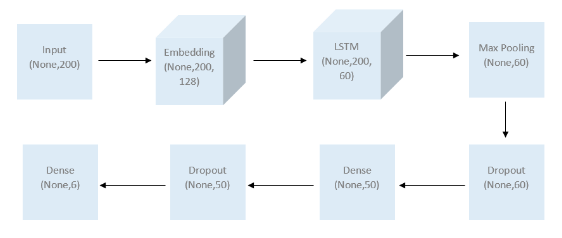

In [20]:
embed_size = 50 # how big is each word vector
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation="sigmoid")(x)# The number of output, here is 6 types of comments
myAI = Model(inputs=inp, outputs=x)
myAI.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(myAI.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 50)           1500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 100)          40400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255 

### Training AI

In [ ]:
print(Bold+ Underline+'The size of the train data:'+End)
print('The Input: %d. The output: %d'%(len(X_train),len(Y)))
print(Bold+ Underline+'The training procedure of AI:'+End)

start = timer()
myTrainedAI=myAI.fit(X_train, Y, batch_size=32, 
                             epochs=2, validation_split=0.3);
#myAI=model.fit(X_ai_train, Y_ai_train, batch_size=32, epochs=10,validation_split=0.0,
 #         validation_data=(X_ai_validation,Y_ai_validation));
print(Bold+"Time %.2fs" % (timer() - start))  

The size of the train data:
The Input: 159571. The output: 159571
The training procedure of AI:
Train on 111699 samples, validate on 47872 samples
Epoch 1/2
111699/111699 [==============================] - 11099s 99ms/step - loss: 0.0778 - acc: 0.9734 - val_loss: 0.0538 - val_acc: 0.9801
Epoch 2/2
101888/111699 [==========================>...] - ETA: 16:47 - loss: 0.0483 - acc: 0.9814

And finally, get predictions for the test set and prepare a submission CSV:

In [11]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'{path}{comp}sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

153164/153164 [==============================] - 113s 740us/step
